# Surival Analysis

### Explain what the project is

In [35]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from random_survival_forest.models import RandomSurvivalForest
from random_survival_forest.scoring import concordance_index

## DATA

In [4]:
# Load the data
df = pd.read_csv('Data/haberman.csv', names = ['Age','Operation_year','Nb_pos_detected','Surv'])

In [5]:
#look at the data
print(df.shape)

df.head()

(306, 4)


,Age,Operation_year,Nb_pos_detected,Surv
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


<Axes: ylabel='Frequency'>

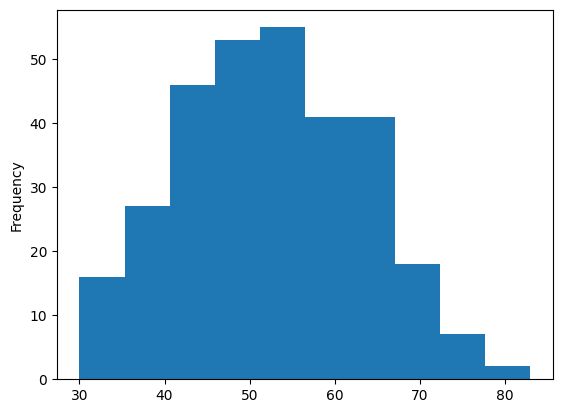

In [6]:
# Distribution of Age
df.Age.plot.hist()

<Axes: ylabel='Frequency'>

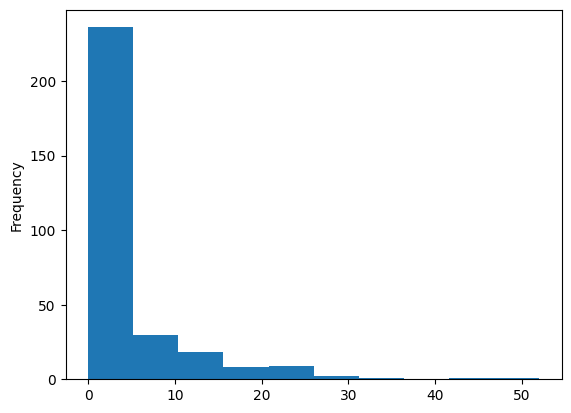

In [7]:
# Distribution of Age
df.Nb_pos_detected.plot.hist()

In [8]:
# percentage of people who did not die in 5 years
df[df.Surv == 1].shape[0] / df.shape[0]

0.7352941176470589

In [9]:
# Another way to look at the data
#import pandas_profiling
#pandas_profiling.ProfileReport(df)


In [10]:
# split data in train, val en test
np.random.seed(0)
df_dev, df_test = train_test_split(df, test_size= 0.2)
df_train, df_val = train_test_split(df, test_size= 0.25)

print("Total number of patients in training set:", df_train.shape[0])
print("Total number of patients in validation set:", df_val.shape[0])
print("Total number of patients in test set:", df_test.shape[0])

Total number of patients in training set: 229
Total number of patients in validation set: 77
Total number of patients in test set: 62


In [11]:
# normalize the continuous covariates

continuous_columns = ['Operation_year','Nb_pos_detected']
mean = df_train.loc[:, continuous_columns].mean()
std = df_train.loc[:, continuous_columns].std()
df_train.loc[:, continuous_columns] = (df_train.loc[:, continuous_columns] - mean) / std
df_val.loc[:, continuous_columns] = (df_val.loc[:, continuous_columns] - mean) / std
df_test.loc[:, continuous_columns] = (df_test.loc[:, continuous_columns] - mean) / std

In [12]:
# check if the normalization worked
df_train.loc[:, continuous_columns].describe()

,Operation_year,Nb_pos_detected
count,2.290000e+02,2.290000e+02
mean,1.755025e-16,6.205613e-17
std,1.000000e+00,1.000000e+00
min,-1.519099e+00,-5.575568e-01
25%,-9.044814e-01,-5.575568e-01
50%,1.744549e-02,-4.225879e-01
75%,9.393724e-01,-1.768150e-02
max,1.861299e+00,6.460822e+00


## Model building

### The Kaplan Meier Estimator

##### We can use this estiamtor to estimate the survivial function
##### Visually we can incpect the probability of an event at a certain time interval.

<Axes: xlabel='timeline'>

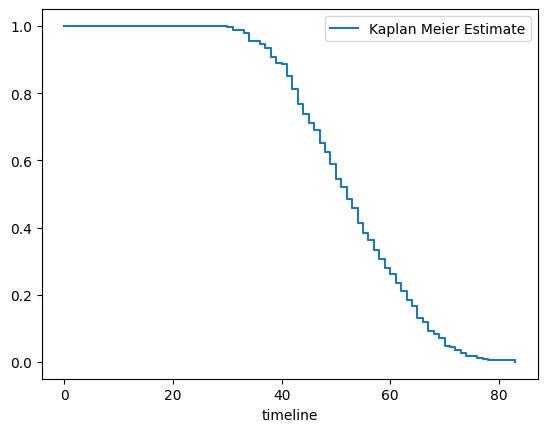

In [13]:
## create a kmf object
km = KaplanMeierFitter() 

## Fit the data into the model
km.fit(df_train.Age, df_train.Surv,label='Kaplan Meier Estimate')

## Create an estimate
km.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, not showing it.

<Axes: xlabel='timeline'>

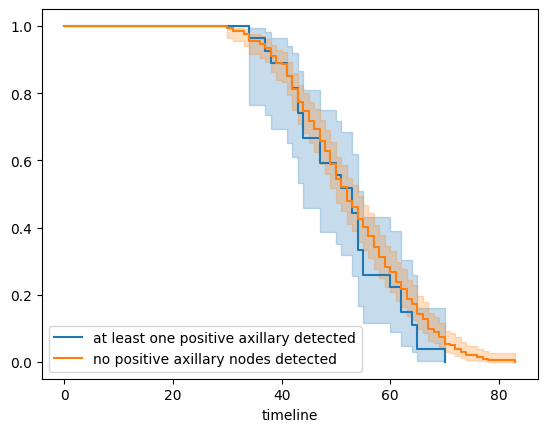

In [14]:
# We can also make different survival groups for subgroups in our data

## Instantiate the class to create an object
km_2 = KaplanMeierFitter()

## creating 2 cohorts : with at least one positive axillary detected, and one with no one detected
groups = df_train['Nb_pos_detected']   
i1 = (groups >= 1)   
i2 = (groups < 1)     


## fit the model for 1st cohort
km_2.fit(df_train.Age[i1], df_train.Surv[i1], label='at least one positive axillary detected')
a1 = km_2.plot()

## fit the model for 2nd cohort
km_2.fit(df_train.Age[i2], df_train.Surv[i2], label='no positive axillary nodes detected')
km_2.plot(ax=a1)

### Cox Proportional Hazards model

#### The Cox model gives us the ability to include covariates in the model.

In [15]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col = 'Age', event_col = 'Surv')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 229 total observations, 0 right-censored observations>
             duration col = 'Age'
                event col = 'Surv'
      baseline estimation = breslow
   number of observations = 229
number of events observed = 229
   partial log-likelihood = -1016.38
         time fit was run = 2023-06-29 15:52:21 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
Operation_year   -0.10       0.90       0.07            -0.23             0.03                 0.80                 1.03
Nb_pos_detected   0.13       1.13       0.07            -0.01             0.26                 0.99                 1.29

                  cmp to     z    p   -log2(p)
covariate                                     
Operation_year      0.00 -1.52 0.13       2.96
Nb_pos_detected     0.00  1.88 0.06       4.07
---
Concordance = 0.54
Partial AIC = 2036.76
log-likelihood ratio test = 5.16 on 2 df
-log2(p) of ll-ratio test = 3.72

<Axes: xlabel='log(HR) (95% CI)'>

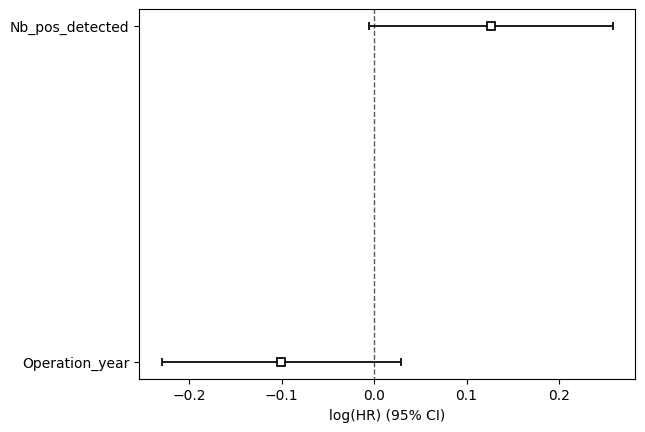

In [16]:
# visualise the signifance and effect of each variable

cph.plot()

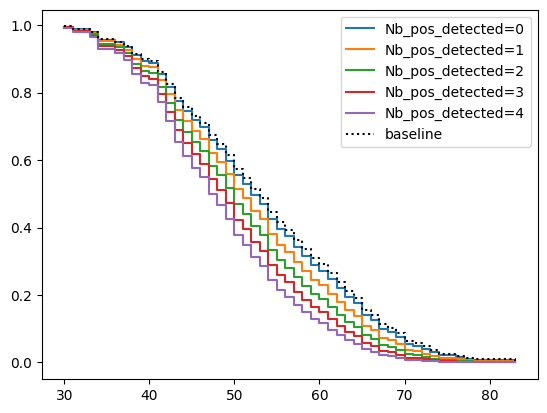

In [17]:
# We can compare the predicted survival curves for different values of variables

cph.plot_covariate_groups('Nb_pos_detected', values=[0, 1, 2, 3, 4]);

In [18]:
# Train
scores = cph.predict_partial_hazard(df_train)
cox_train_scores = cindex(df_train['Age'].values, scores.values, df_train['Surv'].values)
# Validation
scores = cph.predict_partial_hazard(df_val)
cox_val_scores = cindex(df_val['Age'].values, scores.values, df_val['Surv'].values)
# Test
scores = cph.predict_partial_hazard(df_test)
cox_test_scores = cindex(df_test['Age'].values, scores.values, df_test['Surv'].values)

print("Train:", cox_train_scores)
print("Val:", cox_val_scores)
print("Test:", cox_test_scores)

Train: 0.4618991563664901
Val: 0.47654061624649857
Test: 0.4994597514856834


## Random survival forest

In [29]:
# Split the data in the first format
X_train = df_train.drop(["Age","Surv"], axis = 1)
Y_train = df_train.loc[:,["Surv", "Age"]]

X_val = df_val.drop(["Age","Surv"], axis = 1)
Y_val = df_val.loc[:,["Surv", "Age"]]

X_test = df_test.drop(["Age","Surv"], axis = 1)
Y_test = df_test.loc[:,["Surv", "Age"]]

In [53]:
# Build the model
rf = RandomSurvivalForest(n_estimators=100, n_jobs=-1, random_state=10) 
rf = rf.fit(X_train, Y_train)

In [54]:
y_pred = rf.predict(X_test)
c_val = concordance_index(y_time=Y_test["Age"], y_pred=y_pred, y_event=Y_test["Surv"])
print(f'C-index {round(c_val, 3)}')

C-index 0.497


In [51]:
# Hyper parameter optimization
model = RandomSurvivalForest()
param_vals = {'n_estimators': [10, 50, 100, 200],
              'min_leaf': [2,3,4]}

C_all_best = 0
min_leaf_best = 0
n_estimators_best = 0
for i in param_vals["min_leaf"]:
    for j in param_vals["n_estimators"]:
            model = RandomSurvivalForest(n_estimators=j, n_jobs=-1, min_leaf = i, random_state=10)
            y_pred = model.predict(X_test)
            c_val = concordance_index(y_time=Y_test["Age"], y_pred=y_pred, y_event=Y_test["Surv"])

            if c_val > C_all_best:
                  C_all_best = c_val
                  min_leaf_best = i
                  n_estimators_best = j
                  
    
print(f"The performace is C = {C_all_best}, where the best parameters are min_leaf = {min_leaf_best}, n_estimators = {n_estimators_best}")


ZeroDivisionError: division by zero

In [41]:
for i in param_vals["min_leaf"]:
    for j in param_vals["n_estimators"]:
        print(i, j)

2 100
2 200
2 300
2 400
3 100
3 200
3 300
3 400
4 100
4 200
4 300
4 400
